In [58]:
import pandas as pd
data = pd.read_csv('physionet.org/files/mimiciii/1.4/NOTEEVENTS.csv.gz', nrows=10000, compression='gzip',usecols=['TEXT'],
                   error_bad_lines=False)
# Just get 1000 data points and only the text columns

/tmp/ipykernel_9545/105393662.py:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv('physionet.org/files/mimiciii/1.4/NOTEEVENTS.csv.gz', nrows=10000, compression='gzip',usecols=['TEXT'],


In [61]:
import torch
import numpy as np

In [62]:
torch.version.cuda

'11.7'

In [63]:
key_word = ['very','pleasant'] #
pattern = '|'.join(key_word)

In [64]:
data['check'] = data['TEXT'].str.contains(pattern)

In [65]:
data.check.value_counts()

True     7212
False    2788
Name: check, dtype: int64

In [66]:
data.TEXT.head()

0    Admission Date:  [**2151-7-16**]       Dischar...
1    Admission Date:  [**2118-6-2**]       Discharg...
2    Admission Date:  [**2119-5-4**]              D...
3    Admission Date:  [**2124-7-21**]              ...
4    Admission Date:  [**2162-3-3**]              D...
Name: TEXT, dtype: object

In [67]:
data['TEXT'] = data.TEXT.str.replace('[^a-zA-Z1-9]', ' ') # Basic cleaning to remove *or -, can be further customized later

/tmp/ipykernel_9545/2491769875.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  data['TEXT'] = data.TEXT.str.replace('[^a-zA-Z1-9]', ' ') # Basic cleaning to remove *or -, can be further customized later


In [68]:
data['TEXT'].head()

0    Admission Date      2151 7 16          Dischar...
1    Admission Date      2118 6 2          Discharg...
2    Admission Date      2119 5 4                 D...
3    Admission Date      2124 7 21                 ...
4    Admission Date      2162 3 3                 D...
Name: TEXT, dtype: object

## 1: Doc_to_vec

In [11]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /home/gwan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [12]:
sentences = data.TEXT.values
tokenized_sent = []

for s in sentences:
    tokenized_sent.append(word_tokenize(s.lower()))
print(tokenized_sent[0])

['admission', 'date', '2151', '7', '16', 'discharge', 'date', '2151', '8', '4', 'service', 'addendum', 'radiologic', 'studies', 'radiologic', 'studies', 'also', 'included', 'a', 'chest', 'ct', 'which', 'confirmed', 'cavitary', 'lesions', 'in', 'the', 'left', 'lung', 'apex', 'consistent', 'with', 'infectious', 'process', 'tuberculosis', 'this', 'also', 'moderate', 'sized', 'left', 'pleural', 'effusion', 'head', 'ct', 'head', 'ct', 'showed', 'no', 'intracranial', 'hemorrhage', 'or', 'mass', 'effect', 'but', 'old', 'infarction', 'consistent', 'with', 'past', 'medical', 'history', 'abdominal', 'ct', 'abdominal', 'ct', 'showed', 'lesions', 'of', 't1', 'and', 'sacrum', 'most', 'likely', 'secondary', 'to', 'osteoporosis', 'these', 'can', 'be', 'followed', 'by', 'repeat', 'imaging', 'as', 'an', 'outpatient', 'first', 'name8', 'namepattern2', 'first', 'name4', 'namepattern1', '1775', 'last', 'name', 'namepattern1', 'm', 'd', 'md', 'number', '1', '1776', 'dictated', 'by', 'hospital', '18', '7', 

In [13]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(tokenized_sent)]

In [14]:
model_d2v = Doc2Vec(tagged_data, vector_size = 200, window = 2, min_count = 10, epochs = 100)

'''
vector_size = Dimensionality of the feature vectors.
window = The maximum distance between the current and predicted word within a sentence.
min_count = Ignores all words with total frequency lower than this.
alpha = The initial learning rate.
'''

'\nvector_size = Dimensionality of the feature vectors.\nwindow = The maximum distance between the current and predicted word within a sentence.\nmin_count = Ignores all words with total frequency lower than this.\nalpha = The initial learning rate.\n'

In [15]:
data['tokens'] = tokenized_sent

In [16]:
data['emb'] = data['tokens'].apply(model_d2v.infer_vector)

In [17]:
data.head()

,TEXT,check,tokens,emb
0,Admission Date 2151 7 16 Dischar...,False,"[admission, date, 2151, 7, 16, discharge, date...","[0.9194876, 0.31617367, 1.6602403, -0.8010895,..."
1,Admission Date 2118 6 2 Discharg...,False,"[admission, date, 2118, 6, 2, discharge, date,...","[-0.28176105, -1.3940994, 2.023058, 1.3280034,..."
2,Admission Date 2119 5 4 D...,True,"[admission, date, 2119, 5, 4, discharge, date,...","[0.34921858, -1.352876, 1.4489717, 2.0817325, ..."
3,Admission Date 2124 7 21 ...,True,"[admission, date, 2124, 7, 21, discharge, date...","[1.0518075, -1.3964953, 0.12544218, -0.3224223..."
4,Admission Date 2162 3 3 D...,True,"[admission, date, 2162, 3, 3, discharge, date,...","[-0.7803605, -0.006952791, 1.2848545, -0.52551..."


## Transfomer 

In [18]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('TimKond/S-BioLinkBert-MedQuAD')

In [19]:
embeddings = model.encode(sentences)
print(embeddings)

[[ 0.277509    0.26719996 -0.0105282  ... -0.12347386  1.0648662
  -0.17493397]
 [ 0.03479018  0.18932167 -0.02936742 ... -0.05296332  0.73083
  -0.21440667]
 [-0.02235499  0.33601063  0.13468382 ... -0.03416088  0.07084354
  -0.35041183]
 ...
 [-0.1237298   0.33057767  0.28832722 ... -0.15255748  0.23030174
  -0.4573601 ]
 [ 0.04183475  0.24472262  0.10942968 ... -0.05232212  0.44331408
  -0.23331973]
 [-0.05767366  0.21234523  0.21282771 ...  0.09578045 -0.10990594
  -0.38771906]]


## Clustering based on embeddings

In [20]:
from nltk.cluster import KMeansClusterer
import nltk

def clustering_question(data,emb_col,NUM_CLUSTERS = 2):

    X = np.array(data[emb_col].tolist())

    kclusterer = KMeansClusterer(
        NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance,
        repeats=25,avoid_empty_clusters=True)

    assigned_clusters = kclusterer.cluster(X, assign_clusters=True)

    data['cluster'] = pd.Series(assigned_clusters, index=data.index)
    data['centroid'] = data['cluster'].apply(lambda x: kclusterer.means()[x])

    return data

In [21]:
result_d2v = clustering_question(data,'emb')

In [22]:
result_d2v.groupby(["cluster", "check"]).size()

cluster  check
0        False     88
         True     610
1        False    170
         True     132
dtype: int64

In [23]:
data['emb_transformer'] = data['TEXT'].apply(model.encode)

In [24]:
result_trans = clustering_question(data,'emb_transformer')

In [25]:
result_trans.groupby(["cluster", "check"]).size()

cluster  check
0        False    189
         True     550
1        False     69
         True     192
dtype: int64

# Supervised Neural Methods

In [73]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords 
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

def tockenize(x_train,y_train,x_val,y_val):
    word_list = []

    stop_words = set(stopwords.words('english')) 
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
  
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:5000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
    # tockenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                    if preprocess_string(word) in onehot_dict.keys()])
            
    encoded_train = [1 if label == True else 0 for label in y_train]  
    encoded_test = [1 if label == False else 0 for label in y_val] 
    return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict

In [74]:
X,y = data['TEXT'].values,data['check'].values
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')

shape of train data is (7500,)
shape of test data is (2500,)


In [75]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/gwan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [76]:
x_train,y_train,x_test,y_test,vocab = tockenize(x_train,y_train,x_test,y_test)

/tmp/ipykernel_9545/696823680.py:53: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict


In [77]:
print(f'Length of vocabulary is {len(vocab)}')

Length of vocabulary is 5000


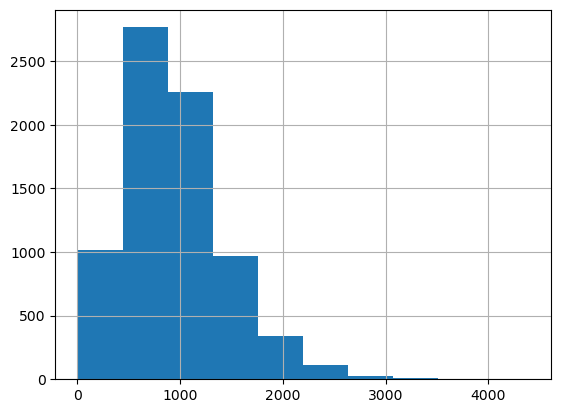

count    7500.000000
mean      946.539733
std       492.109023
min         6.000000
25%       593.000000
50%       879.500000
75%      1221.000000
max      4393.000000
dtype: float64

In [78]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

In [79]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [80]:
x_train_pad = padding_(x_train,3000)
x_test_pad = padding_(x_test,3000)

In [81]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

# dataloaders
batch_size = 32

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [82]:
class SentimentRNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5):
        super(SentimentRNN,self).__init__()
 
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
 
        self.no_layers = no_layers
        self.vocab_size = vocab_size
    
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)
        
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
    
        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()
        
    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 
        
        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
        
        
        
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

In [83]:
no_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256


model = SentimentRNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)

#moving to gpu
model.to(device)

print(model)

SentimentRNN(
  (embedding): Embedding(5001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [55]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [84]:
clip = 5
epochs = 5 
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state 
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        
        inputs, labels = inputs.to(device), labels.to(device)   
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        
        model.zero_grad()
        output,h = model(inputs,h)
        
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
 
    
        
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())
            
            accuracy = acc(output,labels)
            val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), '../working/state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')

In [ ]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

In [ ]:
def predict_text(text):
        word_seq = np.array([vocab[preprocess_string(word)] for word in text.split() 
                         if preprocess_string(word) in vocab.keys()])
        word_seq = np.expand_dims(word_seq,axis=0)
        pad =  torch.from_numpy(padding_(word_seq,500))
        inputs = pad.to(device)
        batch_size = 1
        h = model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = model(inputs, h)
        return(output.item())